# Knowledge Graph Grounding for LLMs in SAP Ecosystem

The *Knowledge Graph Grounding for LLMs* initiative showcases the application of Retrieval-Augmented Generation (RAG) in integrating a Language Model (LLM) with data structured within a Knowledge Graph. This solution encapsulates the entire process, from constructing the Knowledge Graph (KG) from unstructured raw text to building a functional Chat application that can query and interact with this knowledge base.

As part of this R&D project, the following objectives are targeted:

1. **Evaluate LangChain Tools for Knowledge Graph Integration:** - Assess the LangChain ecosystem and its ability to handle interactions with Knowledge Graphs effectively. Specifically, this involves exploring LangChains tools to integrate various data sources, including enterprise-specific databases, into an LLM model.

2. **LLM-Assisted Knowledge Graph Construction:** - Investigate the feasibility of leveraging LLMs to automate the construction of Knowledge Graphs directly from raw text data. This includes exploring techniques for extracting entities, relationships, and attributes from structured and unstructured data sources, and how LLMs can assist in enhancing the accuracy and automation of this process.

3. **Evaluate Triplestore (RDF Store) in HANA Cloud:** - Conduct a hands-on evaluation of working with SAPs HANA Cloud triplestore, an RDF store, which is in Beta at the time of writing. The focus will be on assessing its developer experience, performance, and integration with SAPs broader ecosystem, especially its compatibility with other enterprise systems for managing semantic data.

### Potential Use Cases in SAP:

- **Enterprise Data Integration:** - By grounding LLMs with a Knowledge Graph, SAP systems can significantly enhance data integration and retrieval processes across multiple sources, improving the accuracy and speed of decision-making. This approach can be applied in areas such as finance, procurement, or customer relationship management (CRM).

- **Intelligent Chatbots for Enterprise Applications:** - The constructed Knowledge Graph can be used to power intelligent chatbots integrated into SAP S4HANA or SAP Fiori applications. These chatbots could assist employees with querying operational data, guiding them through business processes, or providing data-driven insights.

- **Automated Data Modeling:** - Using LLMs to assist in the automated creation of Knowledge Graphs from raw text could significantly reduce the time and effort required for data modeling, particularly in complex enterprise systems where textual data is abundant (e.g., contracts, specifications, manuals).

- **Enhanced Business Intelligence (BI):** - Grounding LLMs with structured data stored in a Knowledge Graph can facilitate advanced business intelligence applications. By querying the KG for insights, users can gain a deeper understanding of trends, performance, and operational bottlenecks in real-time.

- **Semantic Search in SAP Solutions:** - Knowledge Graph grounding could enable more advanced semantic search capabilities in SAP solutions, allowing users to query data using natural language and retrieve contextually relevant results rather than relying on traditional keyword-based searches.

**Data sample:**

- https://www.ebmud.com/application/files/3416/7771/2399/2312_-_Four_1500-HP_Main_Air_Compressor_Motors_FINAL.pdf
- https://docs.rs-online.com/d853/A700000006779737.pdf

but you can use your own data in pdf format.


This integration of LLMs with SAP Knowledge Graphs has the potential to transform how organizations manage, retrieve, and utilize enterprise data, particularly in environments that rely heavily on large volumes of unstructured or semi-structured data.

The results of your run may differ from the results in this notebook. Try, improve!


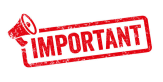

#### **Important Setup:**  .env File Required for AI CORE Access

Before running the application, ensure that the `.env` file is present in the same directory as the source code. This file contains the necessary credentials for accessing AI CORE.

The `.env` file should include the following lines with the appropriate values:

> AICORE_AUTH_URL="https://*xxxxxxx.authentication.eu10.hana.ondemand.com"  
> AICORE_CLIENT_ID= "xxxxxxxx"  
> AICORE_CLIENT_SECRET="xxxxx"  
> AICORE_BASE_URL="https://api.xxxxxxxx.hana.ondemand.com/v2"  
> AICORE_RESOURCE_GROUP="default"


**Make sure to replace the placeholders (`xxxxxxx`) with your actual AI CORE credentials.**


Environment Setup
This  block handles the setup of the environment.
It loads necessary credentials and configurations from a .env file.
Ensure your .env file includes AICORE access details before proceeding.

In [1]:
from dotenv import load_dotenv
_ = load_dotenv()

In [2]:
# Install necessary packages (langchain, rdflib, networkx, matplotlib etc.)
import os
import re
from gen_ai_hub.proxy.langchain.openai import ChatOpenAI
from gen_ai_hub.proxy.core.proxy_clients import get_proxy_client


# Create a proxy client for the AI Hub
proxy_client = get_proxy_client('gen-ai-hub')
chat_llm = ChatOpenAI(proxy_model_name='gpt-4o', proxy_client=proxy_client)

## Data Ingestion
Import raw data from the source. Build the Knowledge Graph using a Language Model (LLM)

In [3]:
from langchain.indexes.graph import GraphIndexCreator
from langchain_community.document_loaders import PyPDFLoader
from prompts import KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT

loader = PyPDFLoader("2312_-_Four_1500-HP_Main_Air_Compressor_Motors_FINAL.pdf")
docs = loader.load()
doc_content = 'This is a compressor specification: '
for doc in docs:
    doc_content = doc_content + ' ' + doc.page_content

index_creator = GraphIndexCreator(llm=chat_llm)

graph = index_creator.from_text(text=doc_content, prompt=KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT)


## Extracted Triples

 **Objective:** Extract knowledge triplets (subject-predicate-object) from the given text.

 **Method:** Use a pre-defined prompt and the OpenAI API to instruct the LLM to extract triplets.

In [4]:
triplets  = graph.get_triples()
print(triplets)

[('East Bay Municipal Utility District', 'Location', 'is a'), ('Four 1500-HP Main Air Compressor Motors', 'Equipment', 'is a'), ('Four 1500-HP Main Air Compressor Motors', '1500-HP power', 'has'), ('Four 1500-HP Main Air Compressor Motors', '4160V', 'operates at'), ('Four 1500-HP Main Air Compressor Motors', '60Hz', 'operates at'), ('Four 1500-HP Main Air Compressor Motors', 'Class F insulation', 'includes'), ('Four 1500-HP Main Air Compressor Motors', 'Class B temperature rise', 'includes'), ('Four 1500-HP Main Air Compressor Motors', 'temperature and vibration monitoring instruments', 'is equipped with'), ('MAC 1-1', 'Equipment', 'is a'), ('MAC 1-2', 'Equipment', 'is a'), ('MAC 2-1', 'Equipment', 'is a'), ('MAC 2-2', 'Equipment', 'is a'), ('MAC motors', 'Westinghouse “Life-Line D” type LAC induction motor', 'includes'), ('MAC motors', '1250Hp power', 'has'), ('MAC motors', '3574 RPM', 'operates at'), ('MAC motors', 'Class F insulation', 'includes'), ('MAC motors', 'Class B temperatur

In [5]:
triplets[0][0]

'East Bay Municipal Utility District'

## KG - Not a pretty visualization
from langchain.indexes.graph

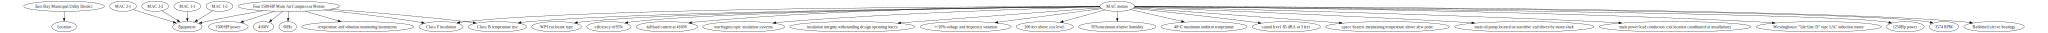

In [6]:
from IPython.display import SVG
graph.draw_graphviz(layout="dot", path="KF_simple.svg")
SVG('KF_simple.svg')

## KG Visualisation

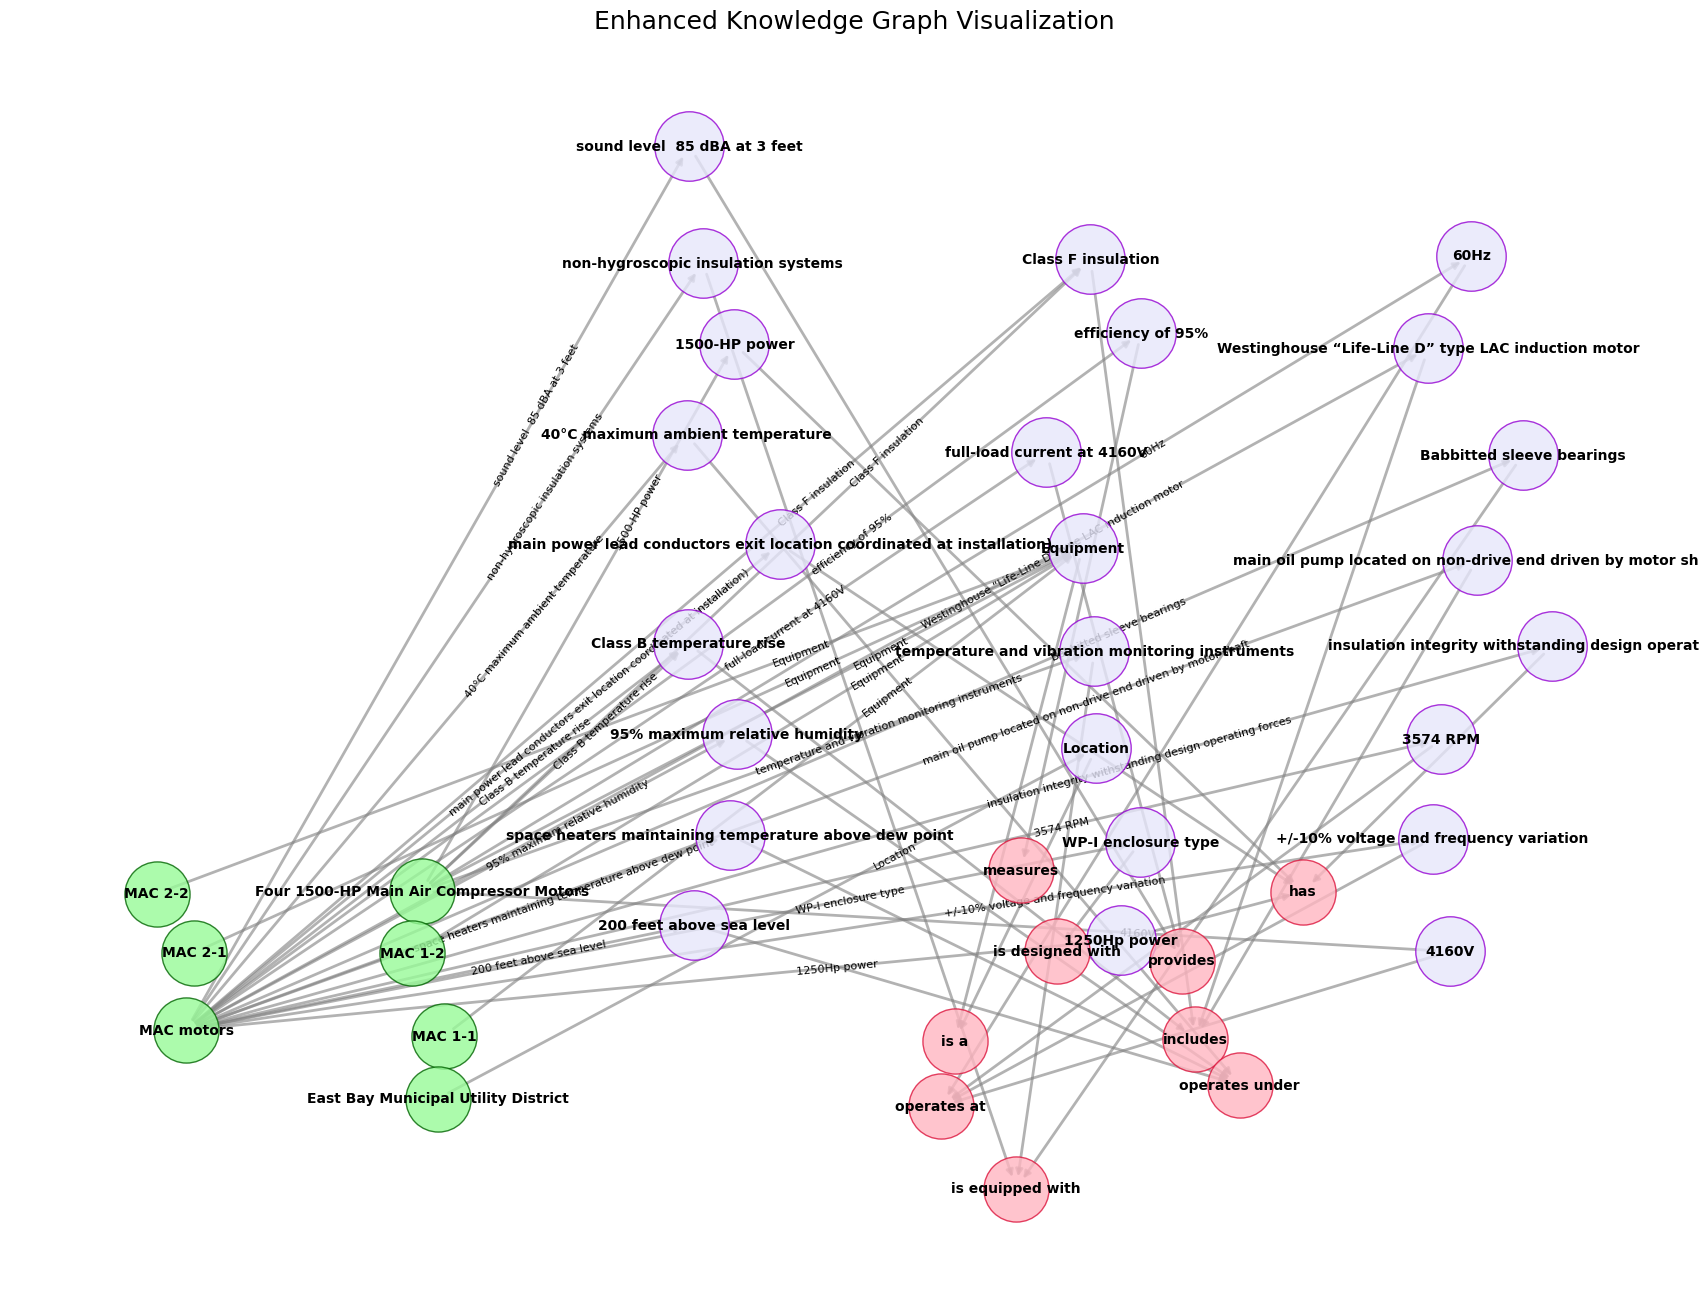

In [7]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_single_graph(graph):
    # Extract triples from the graph
    triples = graph.get_triples()
    G = nx.DiGraph()

    # Collect all types of nodes (subjects, predicates, and objects)
    subjects = {s for s, _, _ in triples}
    predicates = {p for _, p, _ in triples}
    objects = {o for _, _, o in triples}

    # Add nodes and edges based on the triples
    for s, p, o in triples:
        G.add_node(s)
        G.add_node(p)
        G.add_node(o)
        G.add_edge(s, p)
        G.add_edge(p, o)

    # Set the figure size for the visualization
    plt.figure(figsize=(18, 14))
    
    # Layout settings with increased distance between nodes
    pos = nx.spring_layout(G, k=2.0, iterations=200, seed=42)
    
    # Group nodes into categories (predicates, subjects, objects, shared nodes)
    node_groups = {
        "predicates": list(predicates),
        "subjects": list(subjects - predicates - objects),
        "objects": list(objects - subjects - predicates),
        "shared": list((subjects & objects) - predicates)
    }

    # Adjust positions of nodes in each group
    def adjust_positions(nodes, dx_pattern, dy_pattern):
        # Adjust the position of each node based on a pattern
        for i, node in enumerate(nodes):
            x, y = pos[node]
            pos[node] = (
                x + dx_pattern(i), 
                y + dy_pattern(i)
            )

    # Adjust positions for predicates (central nodes)
    adjust_positions(node_groups["predicates"], 
                    lambda i: (i % 3) * 5.5, 
                    lambda i: (i // 3) * 5.5)
    
    # Adjust positions for subjects (left side)
    adjust_positions(node_groups["subjects"],
                    lambda i: -4.0 - (i % 2) * 3.5,
                    lambda i: 3.0 - (i // 2) * 4.0)
    
    # Adjust positions for objects (right side)
    adjust_positions(node_groups["objects"],
                    lambda i: 4.0 + (i % 2) * 3.5,
                    lambda i: 3.0 - (i // 2) * 4.0)
    
    # Adjust positions for shared nodes (bottom part)
    adjust_positions(node_groups["shared"],
                    lambda i: (i % 4) * 2.5 - 5.0,
                    lambda i: -4.0 - (i // 4) * 3.0)

    # Styling for different groups of nodes
    node_styles = {
        "predicates": {'color': '#E6E6FA', 'size': 2500, 'ec': 'darkviolet'},
        "subjects": {'color': '#98FB98', 'size': 2200, 'ec': 'darkgreen'},
        "objects": {'color': '#FFB6C1', 'size': 2200, 'ec': 'crimson'},
        "shared": {'color': '#DDA0DD', 'size': 2400, 'ec': 'purple'}
    }

    # Draw nodes with different styles for each group
    for group, style in node_styles.items():
        nx.draw_networkx_nodes(
            G, pos, nodelist=node_groups[group],
            node_size=style['size'],
            node_color=style['color'],
            edgecolors=style['ec'],
            alpha=0.8
        )

    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    # Draw edges between nodes
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.6, edge_color='gray')
    
    # Draw edge labels (for predicates)
    edge_labels = {(u, v): v if v in predicates else ''
                  for u, v in G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, 
                                font_size=8, label_pos=0.7,
                                bbox=dict(alpha=0))

    # Set title, remove axis, and adjust layout
    plt.title('Enhanced Knowledge Graph Visualization', fontsize=18)
    plt.axis('off')  # Hide axes
    plt.tight_layout(pad=4.0)
    
    # Save the figure and show the plot
    plt.savefig("KF_advanced.png", dpi=300)
    plt.show()


visualize_single_graph(graph)

Let's use the power of SPARQL in SAP HANA

#### **Important Setup:**  .env File Required for HANA Cloud Access

Before running the application, ensure that the `.env` file is present in the same directory as the source code. This file contains the necessary credentials for accessing HANA Cloud.

The `.env` file should include the following lines with the appropriate values:


> hana_address="xxxxx.hanacloud.ondemand.com"  
> hana_port= "443"  
> hana_user="xxxxx"  
> hana_password="xxxxxx"  
> hana_encrypt="default"


#### **Make sure to replace the placeholders (`xxxxxxx`) with your actual HANA Cloud credentials.**

In [8]:
from hdbcli import dbapi
import os
import json
import numpy as np

# Connection parameters
HANA_ADDRESS = os.getenv("hana_address")
HANA_PORT = os.getenv("hana_port")
HANA_USER = os.getenv("hana_user")
HANA_PASSWORD = os.getenv("hana_password")
GRAPH_NAME = "product_custom_HANA_KG"


# Functions for converting values to IRIs and literals
def to_iri(value: str, base: str = "http://example.com/") -> str:
    import re
    encoded_part = re.sub(
        r"[^a-zA-Z0-9\\-_\\.]", lambda m: f"%{ord(m.group(0)):02X}", value
    )
    return f"<{base}{encoded_part}>"

def to_literal(value: str) -> str:
    if value is None:
        return '""'
    escaped = (
        value.replace("\\", "\\\\")
        .replace('"', '\\"')
        .replace("\n", "\\n")
        .replace("\r", "\\r")
    )
    return f'"{escaped}"'


In [9]:
# Connecting to SAP HANA
conn = dbapi.connect(
    address=HANA_ADDRESS, port=HANA_PORT, user=HANA_USER, password=HANA_PASSWORD
)
cursor = conn.cursor()

# Defining IRI for graph
graph_iri = to_iri(GRAPH_NAME, base="http://graph/")

# Inserting graph data
print("[INFO] Inserting data into the graph...")
for idx, (subj, pred, obj) in enumerate(triplets, start=1):
    subj_iri = to_iri(subj, base="http://example.com/resource/")
    pred_iri = to_iri(pred, base="http://example.com/property/")
    obj_literal = to_literal(obj)

    sparql_insert = f"""
    INSERT DATA {{
      GRAPH {graph_iri} {{
        {subj_iri} {pred_iri} {obj_literal} .
      }}
    }}
    """.strip()

    try:
        cursor.callproc("SPARQL_EXECUTE", [sparql_insert, "", None, None])
        print(f"[INFO] Insert row {idx} success.")
    except Exception as e:
        print(f"[ERROR] Insert row {idx} fail: {e}")
        print(f"[ERROR] Query:\n{sparql_insert}")

conn.commit()


[INFO] Inserting data into the graph...
[INFO] Insert row 1 success.
[INFO] Insert row 2 success.
[INFO] Insert row 3 success.
[INFO] Insert row 4 success.
[INFO] Insert row 5 success.
[INFO] Insert row 6 success.
[INFO] Insert row 7 success.
[INFO] Insert row 8 success.
[INFO] Insert row 9 success.
[INFO] Insert row 10 success.
[INFO] Insert row 11 success.
[INFO] Insert row 12 success.
[INFO] Insert row 13 success.
[INFO] Insert row 14 success.
[INFO] Insert row 15 success.
[INFO] Insert row 16 success.
[INFO] Insert row 17 success.
[INFO] Insert row 18 success.
[INFO] Insert row 19 success.
[INFO] Insert row 20 success.
[INFO] Insert row 21 success.
[INFO] Insert row 22 success.
[INFO] Insert row 23 success.
[INFO] Insert row 24 success.
[INFO] Insert row 25 success.
[INFO] Insert row 26 success.
[INFO] Insert row 27 success.
[INFO] Insert row 28 success.
[INFO] Insert row 29 success.
[INFO] Insert row 30 success.
[INFO] Insert row 31 success.


In [10]:
from hdbcli import dbapi
import os

# Form and execute a SPARQL query
sparql_query = f"""
SELECT ?p (COUNT(?o) AS ?count)
FROM {graph_iri}
WHERE {{
  ?s ?p ?o
}}
GROUP BY ?p
ORDER BY DESC(?count)
"""

print("[INFO] Executing SPARQL SELECT query...")
try:
    cursor.execute(f"SELECT * FROM SPARQL_TABLE('{sparql_query}')")
    results = cursor.fetchall()
    if results:
        print("[RESULT] Query results:")
        for row in results:
            print(row)
    else:
        print("[RESULT] No data found.")
except Exception as e:
    print(f"[ERROR] SPARQL SELECT query failed: {e}")

# Closing the connection
cursor.close()
conn.close()
print("[INFO] Connection closed.")


[INFO] Executing SPARQL SELECT query...
[RESULT] Query results:
('http://example.com/property/Equipment', 19)
('http://example.com/property/4160V', 17)
('http://example.com/property/Class%20B%20temperature%20rise', 16)
('http://example.com/property/60Hz', 16)
('http://example.com/property/Class%20F%20insulation', 16)
('http://example.com/property/vibration%20sensors', 15)
('http://example.com/property/noise%20level%2085%20dBA%20at%203%20feet', 6)
('http://example.com/property/efficiency%20of%2095%25%20at%20full%20load', 6)
('http://example.com/property/continuous%20service%20factor%20of%201.15', 5)
('http://example.com/property/noise%20level%20of%2085%20dBA%20at%203%20feet', 5)
('http://example.com/property/1250Hp', 5)
('http://example.com/property/full%20load%20speed%20of%203574%20RPM', 5)
('http://example.com/property/RPM%20of%203574', 5)
('http://example.com/property/temperature%20sensors', 4)
('http://example.com/property/power%20factor%200.936%20or%20higher%20at%20full%20load', 4)

## Graph RAG

Let's find any mentions of industrial standards in the new document.
We will use information from the knowledge graph to provide the LLM with expected values that should be extracted from the text. 🎯



In [11]:
conn = dbapi.connect(
    address=HANA_ADDRESS, port=HANA_PORT, user=HANA_USER, password=HANA_PASSWORD
)
cursor = conn.cursor()

In [12]:
# Form and execute a SPARQL query
identifiers = []

# Let's search the knowledge graph for all possible attributes that relate to industrial standard
sparql_query = """
SELECT DISTINCT "p"
FROM SPARQL_TABLE(
    'SELECT DISTINCT ?p
     WHERE {
       ?s ?p ?o .
       FILTER (
           CONTAINS(STR(?p), "example.com/property") &&
           (
             CONTAINS(LCASE(STR(?p)), "api") ||
             CONTAINS(LCASE(STR(?p)), "ieee") ||
             CONTAINS(LCASE(STR(?p)), "nema") ||
             CONTAINS(LCASE(STR(?p)), "standards") ||
             CONTAINS(LCASE(STR(?p)), "compliance") ||
             CONTAINS(LCASE(STR(?p)), "mg")
           )
       )
     }'
) AS "result"
"""

print("[INFO] Executing SPARQL SELECT query...")
try:
    cursor.execute(sparql_query)
    results = cursor.fetchall()
    if results:
        print("[RESULT] Query results:")
        for row in results:
            print(row)
            if row and row[0]:
                uri = str(row[0])
                identifier = uri.rstrip('/').split('/')[-1]
                identifiers.append(identifier)
    else:
        print("[RESULT] No data found.")
except Exception as e:
    print(f"[ERROR] SPARQL SELECT query failed: {e}")

[INFO] Executing SPARQL SELECT query...
[RESULT] Query results:
('http://example.com/property/enclosure%20type%20NEMA%20WP%2DI',)
('http://example.com/property/NEMA%20WP%2DI%20Enclosure',)
('http://example.com/property/compliance%20with%20API%20541%20standards',)
('http://example.com/property/NEMA%20WP%2DI%20enclosure',)
('http://example.com/property/NEMA%20Standards%20MG%201%2D2006',)
('http://example.com/property/NEMA%20WP%20I%20enclosure',)
('http://example.com/property/API%20541%20compliance',)
('http://example.com/property/compliance%20with%20IEEE%20and%20ANSI%20standards',)
('http://example.com/property/API%20541%20standards',)
('http://example.com/property/IEEE%2085',)


In [13]:
print(identifiers)

['enclosure%20type%20NEMA%20WP%2DI', 'NEMA%20WP%2DI%20Enclosure', 'compliance%20with%20API%20541%20standards', 'NEMA%20WP%2DI%20enclosure', 'NEMA%20Standards%20MG%201%2D2006', 'NEMA%20WP%20I%20enclosure', 'API%20541%20compliance', 'compliance%20with%20IEEE%20and%20ANSI%20standards', 'API%20541%20standards', 'IEEE%2085']


Now let's ask the new document which industry standards are mentioned from those we extracted from the knowledge graph

In [14]:
from langchain.indexes.graph import GraphIndexCreator
from langchain_community.document_loaders import PyPDFLoader
from prompts import KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT_KG_RAG

# Loading new PDF
loader = PyPDFLoader("A700000006779737.pdf")
docs = loader.load()

# Collect content
doc_content = 'This is a compressor specification: '
for doc in docs:
    doc_content += ' ' + doc.page_content

# Setting up attribute list
allowed_attributes = identifiers
allowed_attributes_str = ", ".join(allowed_attributes)


index_creator = GraphIndexCreator(llm=chat_llm)

# Create Grap using updated prompt
graph_selected = index_creator.from_text(
    text=doc_content,
    prompt=KNOWLEDGE_TRIPLE_EXTRACTION_PROMPT_KG_RAG.partial(allowedAttributes=allowed_attributes_str)
)


In [15]:
triplets_selected  = graph_selected.get_triples()
print(triplets_selected)

[('RS PRO 3 Phase AC motor', 'Equipment', 'is a'), ('RS PRO 3 Phase AC motor', 'Frame 71-160', 'has')]
